# Quick demonstration of R-notebooks using the r-oce library

The IOOS notebook
[environment](https://github.com/ioos/notebooks_demos/blob/229dabe0e7dd207814b9cfb96e024d3138f19abf/environment.yml#L73-L76)
installs the `R` language and the `Jupyter` kernel needed to run `R` notebooks.
Conda can also install extra `R` packages,
and those packages that are unavailable in `conda` can be installed directly from CRAN with `install.packages(pkg_name)`.

You can start `jupyter` from any other environment and change the kernel later using the drop-down menu.
(Check the `R` logo at the top right to ensure you are in the `R` jupyter kernel.)

In this simple example we will use two libraries aimed at the oceanography community written in `R`: [`r-gsw`](https://cran.r-project.org/web/packages/gsw/index.html) and [`r-oce`](http://dankelley.github.io/oce/).

(The original post for the examples below can be found author's blog: [http://dankelley.github.io/blog/](http://dankelley.github.io/blog/))

In [4]:
library(gsw)
library(oce)

Example 1: calculating the day length.

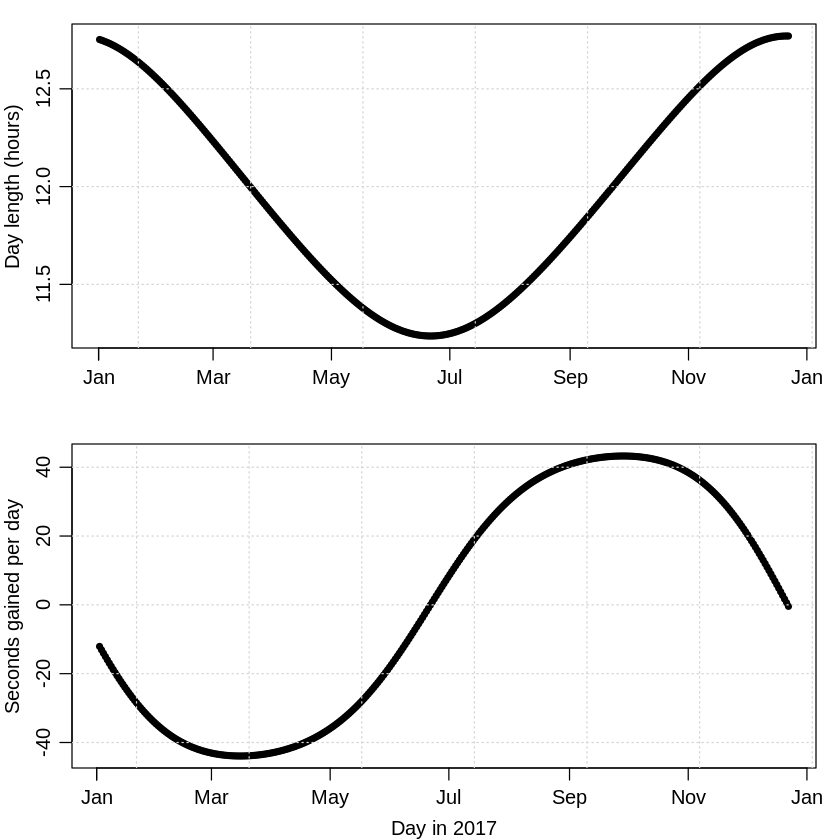

In [5]:
daylength <- function(t, lon=-38.5, lat=-13)
{
    t <- as.numeric(t)
    alt <- function(t)
        sunAngle(t, longitude=lon, latitude=lat)$altitude
    rise <- uniroot(alt, lower=t-86400/2, upper=t)$root
    set <- uniroot(alt, lower=t, upper=t+86400/2)$root
    set - rise
}

t0 <- as.POSIXct("2017-01-01 12:00:00", tz="UTC")
t <- seq.POSIXt(t0, by="1 day", length.out=1*356)
dayLength <- unlist(lapply(t, daylength))

par(mfrow=c(2,1), mar=c(3, 3, 1, 1), mgp=c(2, 0.7, 0))

plot(t, dayLength/3600, type='o', pch=20,
     xlab="", ylab="Day length (hours)")
grid()
solstice <- as.POSIXct("2013-12-21", tz="UTC")

plot(t[-1], diff(dayLength), type='o', pch=20,
     xlab="Day in 2017", ylab="Seconds gained per day")
grid()

Example 2: least-square fit.

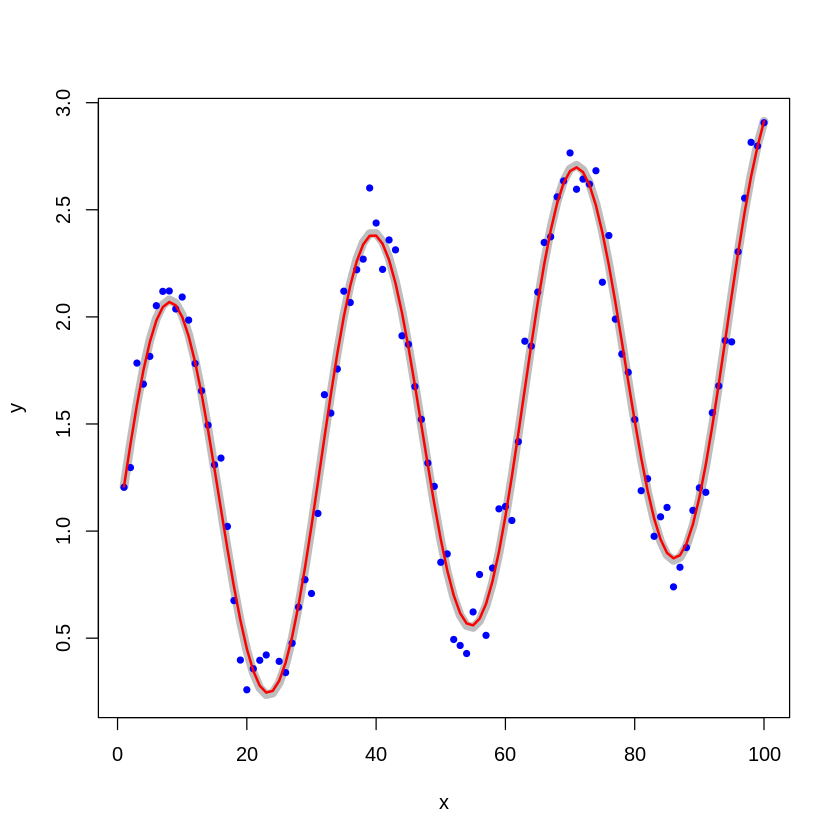

In [7]:
x <- 1:100
y <- 1 + x/100 + sin(x/5)
yn <- y + rnorm(100, sd=0.1)
L <- 4
calc <- runlm(x, y, L=L, deriv=0)
plot(x, y, type='l', lwd=7, col='gray')
points(x, yn, pch=20, col='blue')
lines(x, calc, lwd=2, col='red')

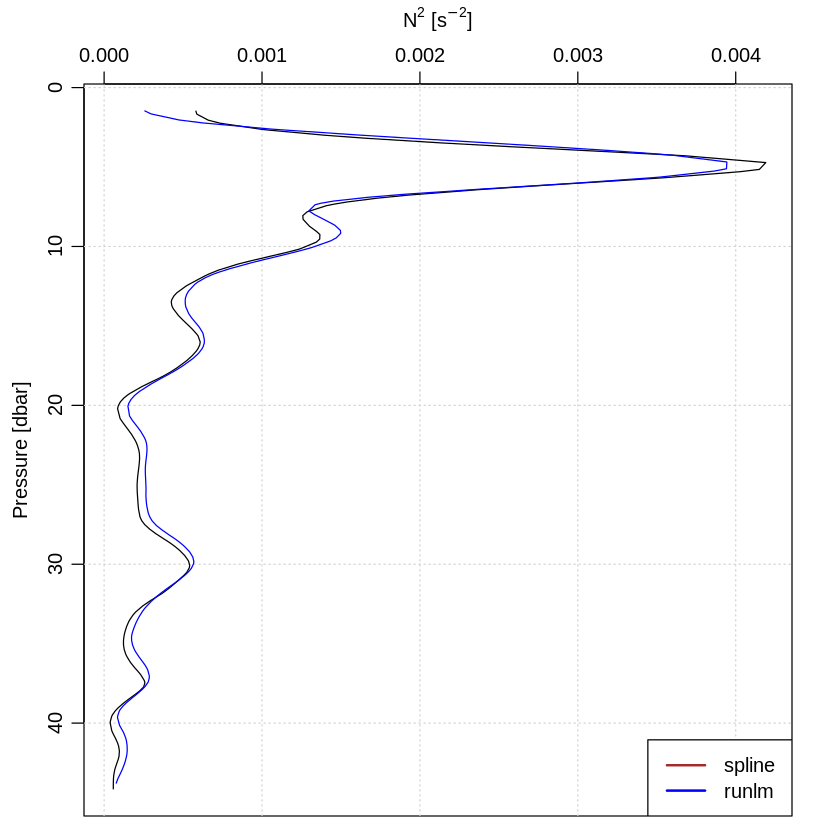

In [8]:
data(ctd)
rho <- swRho(ctd)
z <- swZ(ctd)
drhodz <- runlm(z, rho, deriv = 1)
g <- 9.81
rho0 <- mean(rho, na.rm = TRUE)
N2 <- -g * drhodz/rho0
plot(ctd, which = "N2")
lines(N2, -z, col = "blue")
legend("bottomright", lwd = 2, col = c("brown", "blue"), legend = c("spline", 
    "runlm"), bg = "white")

Example 3: T-S diagram.

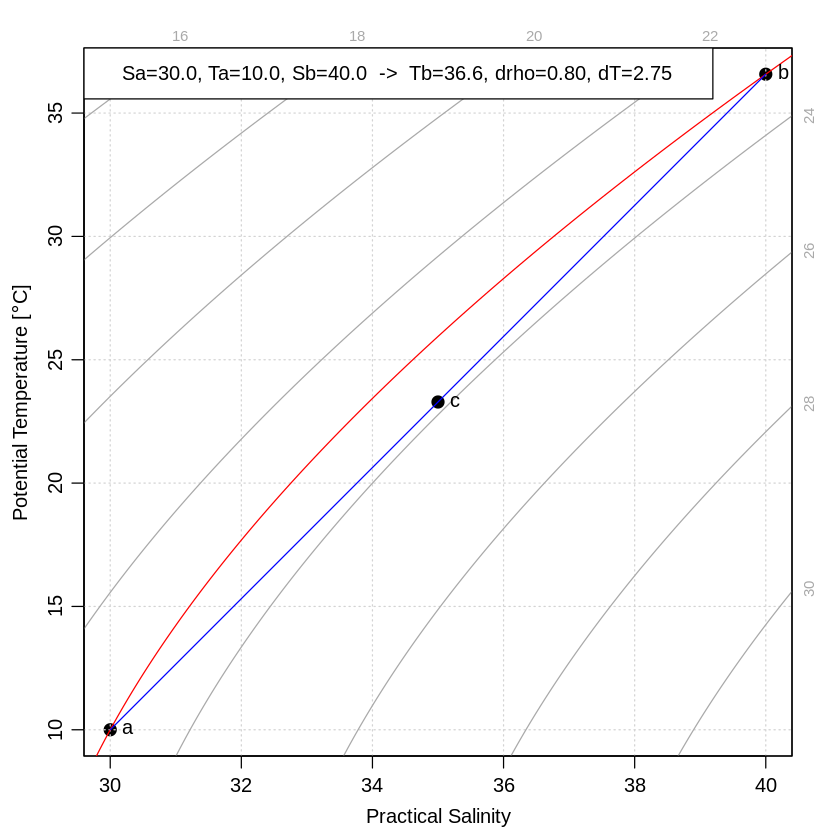

In [9]:
# Alter next three lines as desired; a and b are watermasses.
Sa <- 30
Ta <- 10
Sb <- 40

library(oce)
# Should not need to edit below this line
rho0 <- swRho(Sa, Ta, 0)
Tb <- uniroot(function(T) rho0-swRho(Sb,T,0), lower=0, upper=100)$root
Sc <- (Sa + Sb) /2
Tc <- (Ta + Tb) /2
## density change, and equiv temp change
drho <- swRho(Sc, Tc, 0) - rho0
dT <- drho / rho0 / swAlpha(Sc, Tc, 0)

plotTS(as.ctd(c(Sa, Sb, Sc), c(Ta, Tb, Tc), 0), pch=20, cex=2)
drawIsopycnals(levels=rho0, col="red", cex=0)
segments(Sa, Ta, Sb, Tb, col="blue")
text(Sb, Tb, "b", pos=4)
text(Sa, Ta, "a", pos=4)
text(Sc, Tc, "c", pos=4)
legend("topleft",
       legend=sprintf("Sa=%.1f, Ta=%.1f, Sb=%.1f  ->  Tb=%.1f, drho=%.2f, dT=%.2f",
                      Sa, Ta, Sb, Tb, drho, dT),
       bg="white")

Example 4: find the halocline depth.

[1] 4.292

[1] 4.721

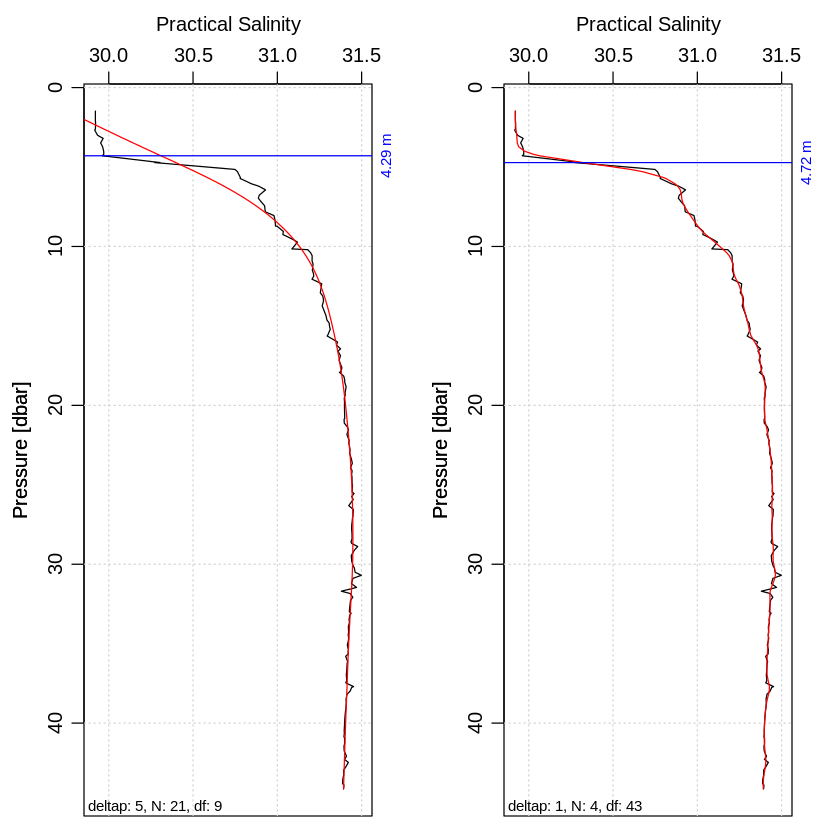

In [10]:
findHalocline <- function(ctd, deltap=5, plot=TRUE)
{
    S <- ctd[['salinity']]
    p <- ctd[['pressure']]
    n <- length(p)
    ## trim df to be no larger than n/2 and no smaller than 3.
    N <- deltap / median(diff(p))
    df <- min(n/2, max(3, n / N))
    spline <- smooth.spline(S~p, df=df)
    SS <- predict(spline, p)
    dSSdp <- predict(spline, p, deriv=1)
    H <- p[which.max(dSSdp$y)]
    if (plot) {
        par(mar=c(3, 3, 1, 1), mgp=c(2, 0.7, 0))
        plotProfile(ctd, xtype="salinity")
        lines(SS$y, SS$x, col='red')
        abline(h=H, col='blue')
        mtext(sprintf("%.2f m", H), side=4, at=H, cex=3/4, col='blue')
        mtext(sprintf(" deltap: %.0f, N: %.0f, df: %.0f", deltap, N, df),
              side=1, line=-1, adj=0, cex=3/4)
    }
    return(H)
}
  
# Plot two panels to see influence of deltap.
par(mfrow=c(1, 2))
data(ctd)
findHalocline(ctd)
findHalocline(ctd, 1)